In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve

### Load the data

In [33]:
df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

### Compute Urea Reduction Rate (URR)

In [34]:
df['URR'] = ((df['BU - pre HD'] - df['BU - post HD']) / df['BU - pre HD']) * 100
df['URR'] = df['URR'].round(3)

### Create the Target

In [35]:
df['target'] = (df['URR'] < 65).astype(int)

#### Sort by Subject_ID and Month to maintain chronological order

In [36]:
df = df.sort_values(by=['Subject_ID', 'Month'])

#### Shift the target backward by 1 row for each patient (next month's target)

In [37]:
df['target_next_month'] = df.groupby('Subject_ID')['target'].shift(-1)
df = df.dropna(subset=['target_next_month']) # Drop rows where next month's target is NaN (last row per patient)

In [38]:
# Convert target_next_month to int (it was float due to NaNs from shift)
df['target_next_month'] = df['target_next_month'].astype(int)

In [39]:
df.head(3)

,Subject_ID,Month,Albumin (g/L),BU - post HD,BU - pre HD,Hb (g/dL),S Ca (mmol/L),SCR- post HD (µmol/L),SCR- pre HD (µmol/L),Serum K Post-HD (mmol/L),Serum K Pre-HD (mmol/L),Serum Na Pre-HD (mmol/L),UA (mg/dL),URR,target,target_next_month
0,RHD_THP_001,2024-01-01,28.6,0.26,13.50,11.0,2.25,96.91,538.0,2.4,4.30,136.0,392.0,98.074,0,0
1,RHD_THP_001,2024-02-01,37.7,0.38,14.14,13.1,2.23,97.37,513.6,2.9,4.32,136.0,408.0,97.313,0,1
2,RHD_THP_001,2024-03-01,40.6,5.85,12.30,12.8,2.24,276.00,560.0,3.9,4.75,141.4,404.0,52.439,1,0


### Define x and y

In [40]:
unique_ids = df['Subject_ID'].unique()

train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = df[df['Subject_ID'].isin(train_ids)]
test_df = df[df['Subject_ID'].isin(test_ids)]

#### Checks for any overlapping Subject_IDs between train and test data.

In [41]:
def check_patient_overlap(train_df, test_df):
    train_ids = set(train_df['Subject_ID'])
    test_ids = set(test_df['Subject_ID'])
    overlapping_ids = train_ids.intersection(test_ids)
    
    if overlapping_ids:
        print("⚠️ Overlapping Subject_IDs found:")
        print(overlapping_ids)
        return True
    else:
        print("✅ No overlapping Subject_IDs.")
        return False

check_patient_overlap(train_df, test_df)

✅ No overlapping Subject_IDs.


False

In [42]:
train_df

,Subject_ID,Month,Albumin (g/L),BU - post HD,BU - pre HD,Hb (g/dL),S Ca (mmol/L),SCR- post HD (µmol/L),SCR- pre HD (µmol/L),Serum K Post-HD (mmol/L),Serum K Pre-HD (mmol/L),Serum Na Pre-HD (mmol/L),UA (mg/dL),URR,target,target_next_month
0,RHD_THP_001,2024-01-01,28.6,0.26,13.50,11.0,2.25,96.91,538.00,2.40,4.30,136.0,392.0,98.074,0,0
1,RHD_THP_001,2024-02-01,37.7,0.38,14.14,13.1,2.23,97.37,513.60,2.90,4.32,136.0,408.0,97.313,0,1
2,RHD_THP_001,2024-03-01,40.6,5.85,12.30,12.8,2.24,276.00,560.00,3.90,4.75,141.4,404.0,52.439,1,0
3,RHD_THP_001,2024-04-01,35.8,6.30,18.90,12.2,1.97,325.40,689.00,4.40,4.20,138.4,487.0,66.667,0,1
4,RHD_THP_001,2024-05-01,36.9,6.75,14.79,12.9,2.53,374.80,601.93,4.90,3.80,138.2,336.0,54.361,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,RHD_THP_045,2024-07-01,31.4,3.54,10.20,8.8,2.30,212.00,398.00,2.80,3.91,135.0,385.0,65.294,0,1
394,RHD_THP_045,2024-08-01,31.4,3.70,8.29,9.6,2.30,162.00,402.50,3.13,3.78,134.6,365.0,55.368,1,0
395,RHD_THP_045,2024-09-01,32.6,0.27,11.37,10.5,2.54,63.80,466.00,2.36,4.20,134.0,345.0,97.625,0,0
396,RHD_THP_045,2024-10-01,32.6,0.27,8.50,11.3,2.54,63.80,397.00,2.36,4.20,134.0,345.0,96.824,0,0


In [43]:
X_train = train_df.drop( columns=["Subject_ID", "Month", "URR", "target", "target_next_month"] )
y_train = train_df["target_next_month"]

X_test = test_df.drop( columns=["Subject_ID", "Month", "URR", "target", "target_next_month"] )
y_test = test_df["target_next_month"]

In [44]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (288, 11) (288,)
Test set shape: (68, 11) (68,)


# Train the ML Model

- 288 training samples
- 11 features
- Binary classification task (URR < 65 as target)

## Random Forest

In [45]:
modelRandomForest = RandomForestClassifier(random_state=42)
modelRandomForest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## XGBoost

In [46]:
modelXGBoost = XGBClassifier(random_state=42)
modelXGBoost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Support Vector Machine (SVM)

In [47]:
modelSVM = SVC(probability=True)
modelSVM.fit(X_train, y_train)

SVC(probability=True)

## Logistic Regression

In [48]:
modelLogisticRegression = LogisticRegression()
modelLogisticRegression.fit(X_train, y_train)

C:\Users\Lakshitha Kaveen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## LightGBM

In [49]:
modelLightGBM = LGBMClassifier(random_state=42)
modelLightGBM.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 78, number of negative: 210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270833 -> initscore=-0.990399
[LightGBM] [Info] Start training from score -0.990399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(random_state=42)

# Evaluate the Models

In [50]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test)
        else:
            print(f"Skipping ROC for {name} (no probability or decision function).")
            continue
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test)
        else:
            print(f"Skipping PR curve for {name} (no probability or decision function).")
            continue
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        plt.plot(recall, precision, label=name)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_feature_importance(model, X_train, model_name):
    if hasattr(model, 'feature_importances_'):
        fi = model.feature_importances_
        indices = fi.argsort()[::-1]
        features = X_train.columns

        plt.figure(figsize=(10,6))
        sns.barplot(x=fi[indices], y=features[indices])
        plt.title(f'Feature Importance for {model_name}')
        plt.show()
    else:
        print(f"No feature importance available for {model_name}.")

In [51]:
models = {
    'Random Forest': modelRandomForest,
    'XGBoost': modelXGBoost,
    'LightGBM': modelLightGBM,
    'Logistic Regression': modelLogisticRegression,
    'SVM': modelSVM
}

Model: Random Forest


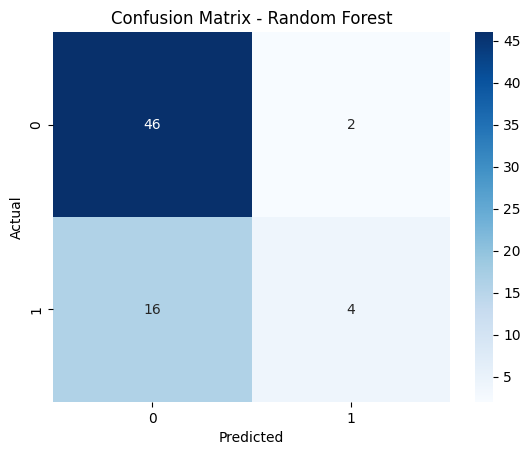

Model: XGBoost


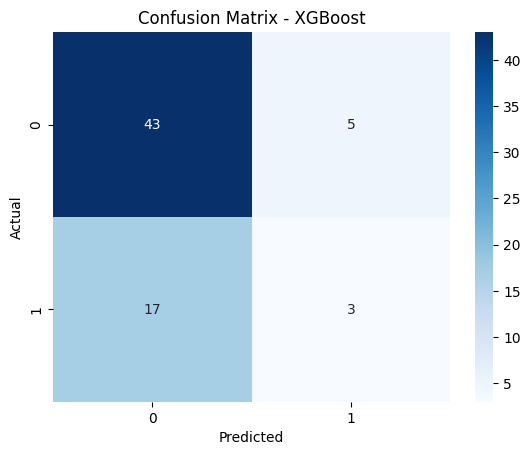

Model: LightGBM


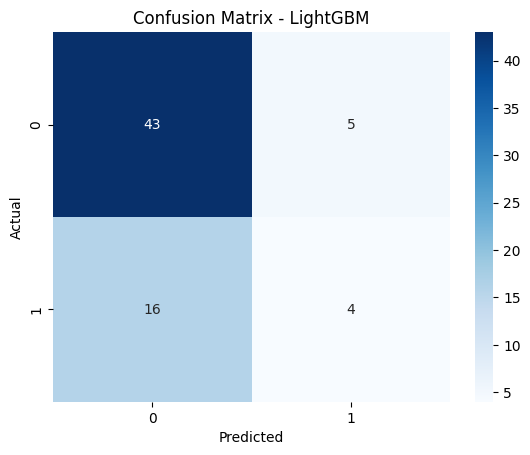

Model: Logistic Regression


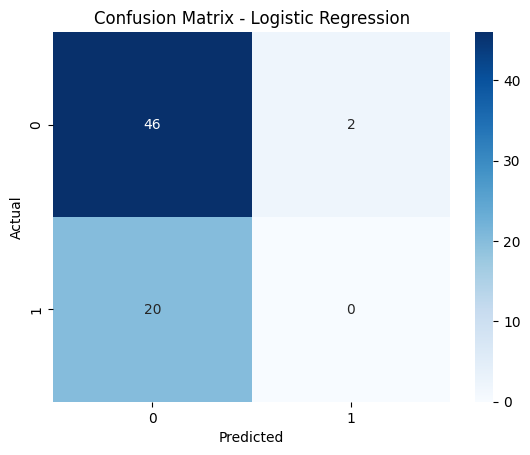

Model: SVM


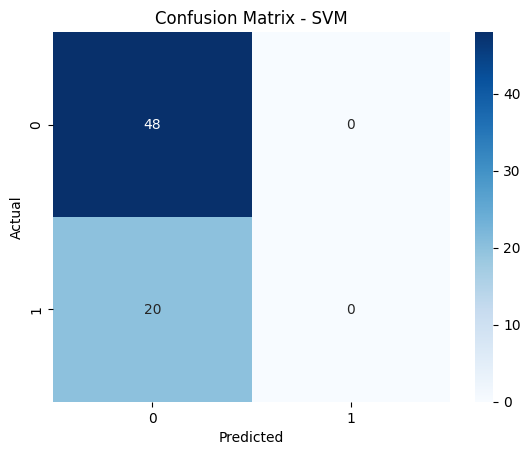

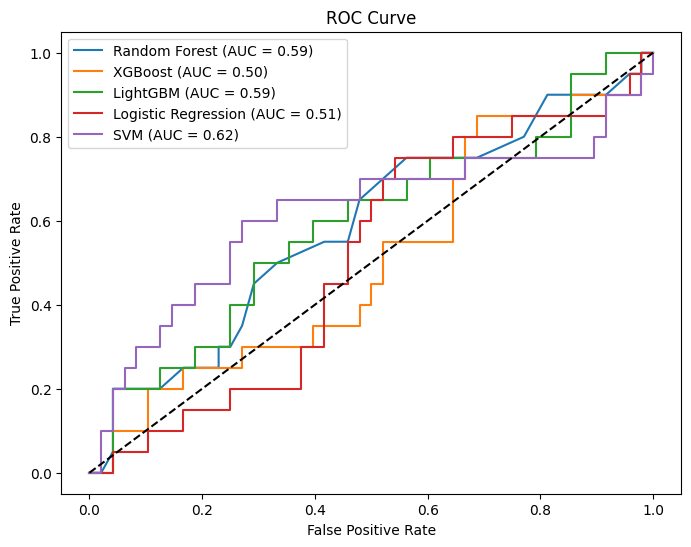

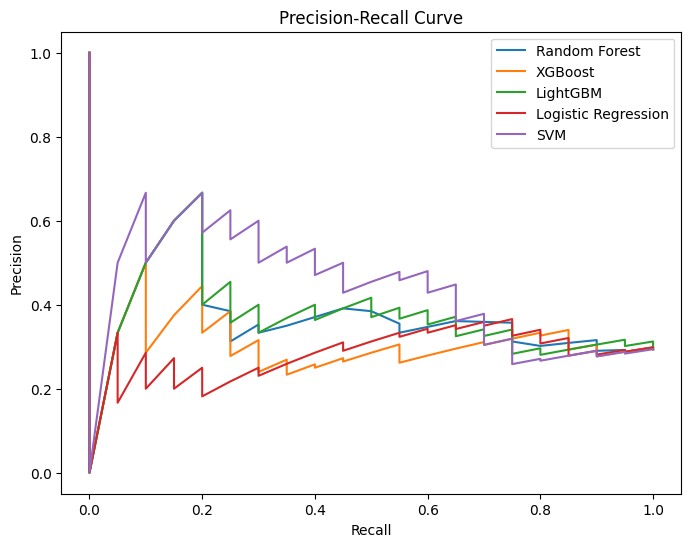

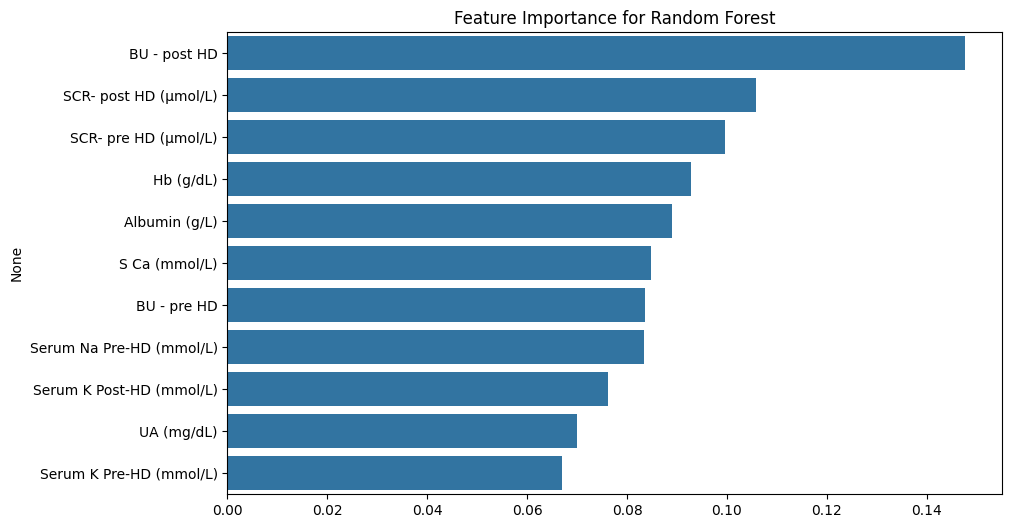

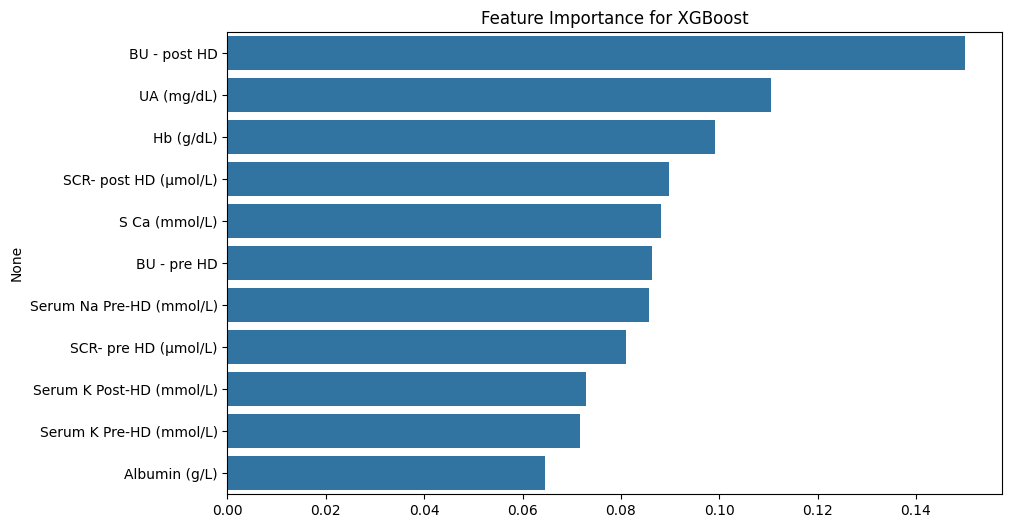

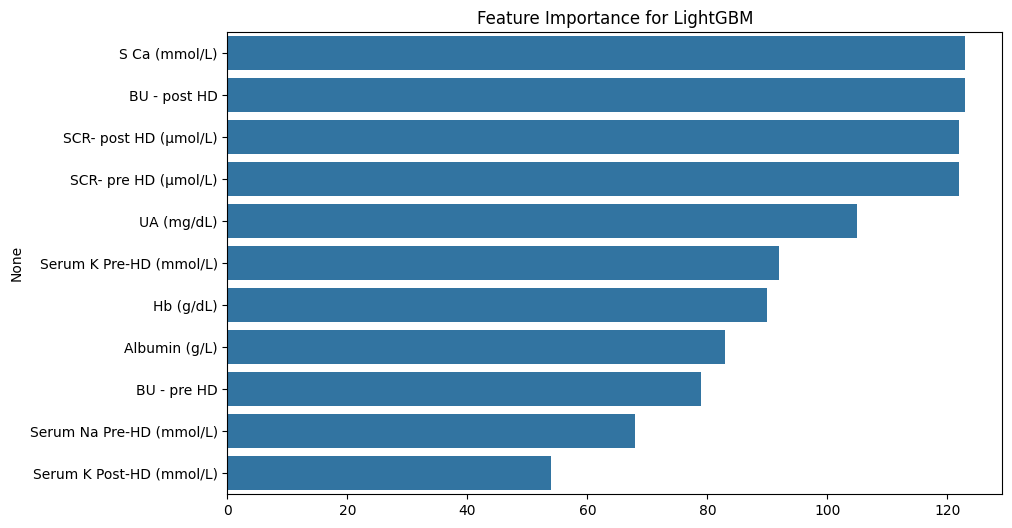

No feature importance available for Logistic Regression.
No feature importance available for SVM.


In [52]:
# Plot confusion matrices
for name, model in models.items():
    print(f"Model: {name}")
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix - {name}')

# Plot ROC curves
plot_roc_curve(models, X_test, y_test)

# Plot Precision-Recall curves
plot_precision_recall_curve(models, X_test, y_test)

# Plot feature importance for tree-based models
for name, model in models.items():
    plot_feature_importance(model, X_train, name)